In [ ]:
!pip install pybullet
!pip install openthechests
!pip install gym matplotlib
!pip install imageio-ffmpeg
!pip install numpy==1.23
!pip install tensorflow==2.12
!pip install sb3-contrib
!pip install gymnasium stable-baselines3[extra] shimmy

In [ ]:
# Standard library
import os
import sys
import math
import random
import itertools
from collections import deque, defaultdict, namedtuple
from itertools import count, product

# Third-party libraries
import numpy as np
import matplotlib.pyplot as plt
import gym
import gymnasium as gym
import pybullet as p
import pybullet_data
import imageio_ffmpeg
from base64 import b64encode
from IPython import display as ipythondisplay
from IPython.display import HTML

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as T

# Stable-Baselines3
from stable_baselines3.common.vec_env import DummyVecEnv, VecMonitor

# Local imports
from register_envs import all_types, all_attributes, register_custom_envs

from stable_baselines3 import PPO


# Apprentissage par renforcement pour la reconnaissance et l'exécution de tâches robotiques dans des environnements pilotés par des événements

#### Récapitulatif des instructions: 

Ce projet mettra en oeuvre un algorithme d’apprentissage par renforcement (RL) afin de permettre à un bras robotique d’interagir avec la bonne boîte en fonction des événements observables. L’objectif est de développer un système basé sur le RL dans lequel un robot peut reconnaître et réagir à des situations complexes de prise de décision séquentielle dans un environnement dynamique et orienté événements. Plus précisément, le robot contrôlera un bras robotique capable de réagir à ces situations changeantes.

Pour y parvenir, nous utiliserons des simulateurs tels que PyBullet pour les tâches robotiques, ainsi que l’environnement Open the Chests (OtC) pour traiter des défis complexes de prise de décision séquentielle. L’environnement Open the Chests fournit un monde basé sur des événements séquentiels, dans lequel le robot peut observer et prendre des décisions éclairées. Parallèlement, PyBullet sera utilisé pour simuler le contrôle du bras robotique, lui permettant ainsi de réagir physiquement aux situations et de manipuler des objets.

Le but est de développer un système dans lequel le robot peut identifier de manière autonome des motifs d’événements, prendre des décisions et agir afin d’interagir efficacement avec son environnement.





## 1. Environnement de simulation RL basé sur PyBullet

L’objectif de la version v0 est de permettre à un bras robotique KUKA d’atteindre un coffre cible, choisi aléatoirement parmi trois positions fixes disposées sur une table. La politique est apprise à l’aide de PPO (Proximal Policy Optimization), un algorithme bien adapté aux espaces d’action continus.

Afin de favoriser l’apprentissage d’une stratégie généralisable, le coffre cible est sélectionné de manière aléatoire à chaque épisode.

Remarque: 
- Environnement physique simulé : plan, table, bras robotique KUKA et trois coffres placés à des coordonnées constantes.
- Contrôle moteur : cinématique inverse permettant une conversion directe des actions en mouvements articulaires réalistes.
- Espace d’action : translation 3D bornée entre −0.05 et +0.05 m, imposant des mouvements courts et progressifs, stabilisant l’apprentissage.
- Fonction de récompense continue : récompense principale = distance euclidienne négative entre l’effecteur et le but; +10 si distance < 5 cm; +10 supplémentaires en cas de contact physique avec le coffre cible.

In [ ]:
%%bash
cat > /content/kuka_env_file.py << 'EOF'

class MultiGoalKukaEnv(gym.Env):
    metadata = {"render_modes": ["human"]}

    def __init__(self, chest_xy=None, max_steps=300):
        super().__init__()
        self.max_steps = max_steps
        self.chest_xy = chest_xy or [(0.75, -0.2), (0.85, 0.0), (0.95, 0.2)]
        self._rng = np.random.default_rng()

        self.action_space = gym.spaces.Box(-0.05, 0.05, (3,), np.float32)
        self.observation_space = gym.spaces.Dict({
            "observation":   gym.spaces.Box(-np.inf, np.inf, (10,), np.float32),
            "desired_goal":  gym.spaces.Box(-np.inf, np.inf, (3,),  np.float32),
            "achieved_goal": gym.spaces.Box(-np.inf, np.inf, (3,),  np.float32),
        })
        self.client = None

    def compute_reward(self, achieved_goal, desired_goal, info):
        return -np.linalg.norm(achieved_goal - desired_goal)

    def reset(self, seed=None, options=None):
        # connexion ou reset de la simu
        if self.client is None:
            self.client = p.connect(p.DIRECT)
        else:
            p.resetSimulation(physicsClientId=self.client)

        # setup de la scène
        p.setAdditionalSearchPath(pybullet_data.getDataPath())
        p.setGravity(0, 0, -10, physicsClientId=self.client)
        p.loadURDF("plane.urdf", physicsClientId=self.client)
        table_id = p.loadURDF(
            "table/table.urdf",
            basePosition=[1.0, -0.2, 0.0],
            baseOrientation=[0, 0, 0, 1],
            physicsClientId=self.client
        )
        top_z = p.getAABB(table_id, physicsClientId=self.client)[1][2]

        # robot
        self.kuka = p.loadURDF(
            "kuka_iiwa/model_vr_limits.urdf",
            basePosition=[1.4, -0.2, 0.6],
            physicsClientId=self.client
        )

        # cubes
        half = 0.025
        for cid in getattr(self, "cubes", []):
            p.removeBody(cid)
        self.cubes = []
        for x, y in self.chest_xy:
            cid = p.loadURDF(
                "cube.urdf",
                basePosition=[x, y, top_z + half],
                globalScaling=0.05,
                physicsClientId=self.client
            )
            self.cubes.append(cid)

        # échantillonnage du goal
        idx = self._rng.integers(len(self.cubes))
        self.current_idx = idx
        self.goal = np.array(self.chest_xy[idx] + (top_z + half,), dtype=np.float32)

        # reset articulations
        init_j = [0, 0, 0, 1.5708, 0, -1.0367, 0]
        for j in range(p.getNumJoints(self.kuka, physicsClientId=self.client)):
            p.resetJointState(self.kuka, j, init_j[j], physicsClientId=self.client)
            p.setJointMotorControl2(
                self.kuka, j, p.POSITION_CONTROL,
                targetPosition=init_j[j],
                physicsClientId=self.client
            )

        self.step_count = 0
        obs, _ = self._get_obs_dict()
        return obs, {}

    def step(self, action):
        # calcule nouvelle cible pour l’effector
        ee = np.array(
            p.getLinkState(self.kuka, 6, physicsClientId=self.client)[0],
            dtype=np.float32
        )
        target = (ee + np.clip(action, -0.05, 0.05)).tolist()
        orn = p.getQuaternionFromEuler([0, math.pi, 0])
        joints = p.calculateInverseKinematics(
            self.kuka, 6, target, orn,
            physicsClientId=self.client
        )
        for j in range(7):
            p.setJointMotorControl2(
                self.kuka, j, p.POSITION_CONTROL,
                targetPosition=joints[j],
                physicsClientId=self.client
            )

        p.stepSimulation(physicsClientId=self.client)
        self.step_count += 1

        # observation
        obs, achieved = self._get_obs_dict()

        # distance euclidienne
        dist = np.linalg.norm(achieved - self.goal)
        reward = -dist
        terminated = False

        # 1) bonus distance < 5 cm
        if dist < 0.05:
            reward += 10.0
            terminated = True

        # 2) détection de contact physique
        contacts = p.getContactPoints(
            bodyA=self.kuka,
            bodyB=self.cubes[self.current_idx],
            physicsClientId=self.client
        )
        if len(contacts) > 0:
            # épisode fini immédiatement au premier contact
            reward += 10.0
            terminated = True

        # 3) check max steps
        truncated = (self.step_count >= self.max_steps)

        info = {"is_success": terminated}
        return obs, reward, terminated, truncated, info

    def _get_obs_dict(self):
        js = np.array(
            [s[0] for s in p.getJointStates(self.kuka, list(range(7)), physicsClientId=self.client)],
            dtype=np.float32
        )
        ee = np.array(
            p.getLinkState(self.kuka, 6, physicsClientId=self.client)[0],
            dtype=np.float32
        )
        obs = np.concatenate([js, ee])
        return (
            {
                "observation":   obs,
                "desired_goal":  self.goal,
                "achieved_goal": ee,
            },
            ee
        )

    def close(self):
        if self.client is not None:
            p.disconnect(self.client)
            self.client = None
EOF

In [ ]:
# Entraînement PPO
vec_env = DummyVecEnv([lambda: MultiGoalKukaEnv()])
vec_env = VecMonitor(vec_env)
model = PPO("MultiInputPolicy", vec_env, verbose=1, tensorboard_log="./ppo_logs")
model.learn(total_timesteps=300_000)
model.save("ppo_kuka_multigoal")

Using cpu device
Logging to ./ppo_logs/PPO_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 295      |
|    ep_rew_mean     | -138     |
|    success_rate    | 0.167    |
| time/              |          |
|    fps             | 668      |
|    iterations      | 1        |
|    time_elapsed    | 3        |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 297          |
|    ep_rew_mean          | -131         |
|    success_rate         | 0.154        |
| time/                   |              |
|    fps                  | 545          |
|    iterations           | 2            |
|    time_elapsed         | 7            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0078649605 |
|    clip_fraction        | 0.0662       |
|    clip_range       

#### Analyse des résultats d’apprentissage:

Après un entraînement de 300 000 pas de temps, les indicateurs fournis par le logger confirment une excellente convergence de la politique apprise: en effet le taux de succès atteint 1.0, ce qui signifie que le robot parvient systématiquement à accomplir la tâche assignée. Il est capable de toucher le coffre cible à chaque épisode. L’entropie basse (−2.39) et la variance expliquée élevée (0.984) indiquent que la politique est à la fois stable et bien adaptée à l’environnement. 

Ce résultat est la preuve directe que l’agent a réellement appris un comportement efficace et généralisable. 

## 2. Environnement "Open the Chests"

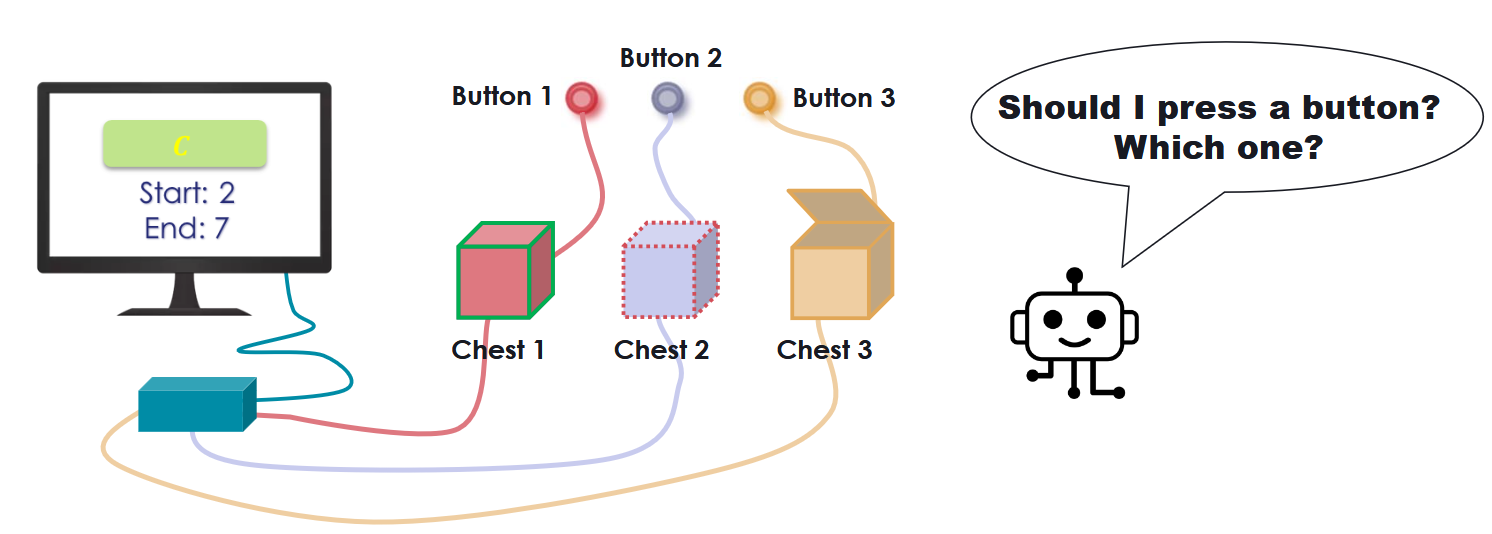




In [ ]:
def event_from_obs_gym(obs, types, attributes):
    """
    Extracts event information from the environment observation.
    Converts indices into human-readable symbols and colors.
    """
    return {
        "symbol": types[obs["e_type"]],  # Convert event index to actual event type
        "bg_color": attributes["bg"][obs["bg"]],  # Convert bg index to color
        "symbol_color": attributes["fg"][obs["fg"]],  # Convert fg index to color
        "start_time": obs["start"][0],
        "end_time": obs["end"][0]}

register_custom_envs()

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [6]:
# set up matplotlib
is_ipython = 'inline' in plt.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

### Open the chest -v0

Pour la version V0 de OpenTheChests, un simple DQN a été utilisé. Il n'y a pas besoin de garder en mémoire les évenements précédent car un évenement entraine une action. La partie observable de l'environnement comprends les états "active" et "open" que l'on concataine en un seul vecteur. A partir de cela, l'agent choisi une action à réaliser. On peut voir que la loss diminue très vite ce qui laisse penser que l'agent a très vite appris. Il n'y a presque pas de variance donc l'apprentissage semble être stable. Néanmoins ce la ne signifie pas frocément que la policy apprise est bonne. 
Lorsque l'on teste l'agent, on peut voir que les rewards cumulés par épisode sont majoritairement au dessus de 0 donc l'agent semble avoir appris au moins un peu. Par contre, il reste encore des rewards cumulés négatifs donc l'agent se trompe encore.

In [8]:
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [45]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [10]:
def select_action(state, policy_net, steps_done, EPS_START=0.9, EPS_END=0.05, EPS_DECAY=10):
      sample = random.random()
      eps_threshold = EPS_END + (EPS_START - EPS_END) * \
          np.exp(-1. * steps_done / EPS_DECAY)
      steps_done += 1

      if sample > eps_threshold:
          with torch.no_grad():
              q_values = policy_net(state)
              action_index = q_values.argmax(dim=1).item()
      else:
          action_index = random.randrange(len(action_space))

      return action_index, steps_done

In [ ]:
# Generate all possible 3-bit button combinations
action_space = list(itertools.product([0, 1], repeat=3))  # 8 possible actions


In [12]:
print(action_space)

[(0, 0, 0), (0, 0, 1), (0, 1, 0), (0, 1, 1), (1, 0, 0), (1, 0, 1), (1, 1, 0), (1, 1, 1)]


In [13]:
def optimize_model(policy_net,target_net,optimizer):
    if len(memory) < batch_size:
        return
    transitions = memory.sample(batch_size)

    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(batch_size, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()

    expected_state_action_values = (next_state_values * gamma) + reward_batch

    # Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    #MSE loss
    #loss = F.mse_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad() #zeroes the gradient buffers of all parameters, so as not to accumulate to existing gradients
    loss.backward()       #backpropagate the error
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()      #does the update

    return loss.item()

In [ ]:
num_episodes = 1200
memory = ReplayMemory(1000)
lr = 1e-4
batch_size = 128
target_update = 10
gamma = 0.7

def training(env_name,num_episodes) :
  rewards_list = []
  losses = []

  env = gym.make(env_name)

  # Get the number of state observations
  state = env.reset()
  n_observations = 6
  n_actions = 8

  policy_net = DQN(n_observations, n_actions).to(device)
  target_net = DQN(n_observations, n_actions).to(device)
  target_net.load_state_dict(policy_net.state_dict())

  optimizer = optim.AdamW(policy_net.parameters(), lr=lr, amsgrad=True)

  steps_done = 0
  episode_durations = []

  for i_episode in range(num_episodes):
      episode_loss_values = []

      reward_per_episode =0
      state = env.reset()

      state_values = np.concatenate([state['active'], state['open']]).astype(np.float32)
      state = torch.tensor(state_values, dtype=torch.float32, device=device).unsqueeze(0)

      for t in count():
          # select, perform an action and observe reward and new state
          action_index, steps_done = select_action(state, policy_net, steps_done)
          action_vector = list(action_space[action_index])
          action_tensor = torch.tensor([[action_index]], device=device, dtype=torch.long)
          # observe new state
          observation, reward, done, info= env.step(action_vector)
          reward_per_episode += reward
          reward = torch.tensor([reward], device=device)

          if done:
            next_state = None
          else:
            next_state_values = np.concatenate([observation['active'], observation['open']]).astype(np.float32)
            next_state = torch.tensor(next_state_values, dtype=torch.float32, device=device).unsqueeze(0)

          # Store the transition in memory
          memory.push(state, action_tensor, next_state, reward)

          state = next_state

          loss=optimize_model(policy_net,target_net,optimizer)
          if loss is not None: episode_loss_values.append(loss)

          if i_episode % target_update == 0:
              target_net.load_state_dict(policy_net.state_dict())
          if done:
              rewards_list.append(reward_per_episode)
              if episode_loss_values:
                avg_loss = sum(episode_loss_values) / len(episode_loss_values)
                losses.append(avg_loss)
              else:
                losses.append(0.0)

              break

  torch.save(policy_net.state_dict(), "policy_net_V0.pth")

  return rewards_list, losses, policy_net

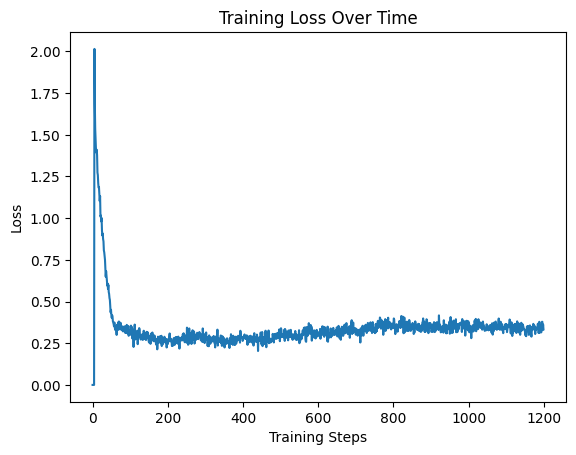

In [51]:
rewards_list,losses, policy_net =training("OpenTheChests-v0",num_episodes)

plt.figure()
plt.plot(losses)
plt.title('Training Loss Over Time')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.show()

In [143]:
def test_agent(policy_net, env_name, num_episodes):
  env = gym.make(env_name)
  rewards = []

  for episode in range(num_episodes):
      obs = env.reset()
      state_values = np.concatenate([obs['active'], obs['open']]).astype(np.float32)
      state = torch.tensor(state_values, dtype=torch.float32).unsqueeze(0)

      total_reward = 0

      for t in count():
          with torch.no_grad():
              q_values = policy_net(state)
              action_index = q_values.argmax().item()

          action_vector = list(action_space[action_index])
          obs, reward, done, _ = env.step(action_vector)
          total_reward += reward

          if done:
              break

          next_state_values = np.concatenate([obs['active'], obs['open']]).astype(np.float32)
          state = torch.tensor(next_state_values, dtype=torch.float32).unsqueeze(0)

      rewards.append(total_reward)

  env.close()
  avg_reward = sum(rewards) / len(rewards)
  print(f"Average reward over {num_episodes} episodes: {avg_reward:.2f}")
  return rewards

In [144]:
test_rewards = test_agent(policy_net,"OpenTheChests-v0", num_episodes=1000)

/usr/local/lib/python3.11/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment OpenTheChests-v0 is out of date. You should consider upgrading to version `v2`.
  logger.warn(


Average reward over 1000 episodes: 1.64


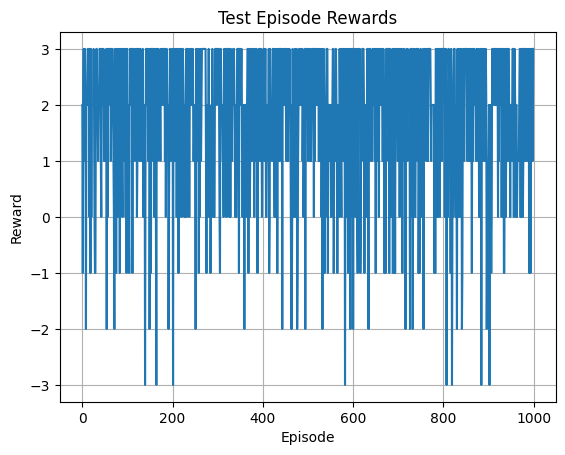

In [58]:
plt.plot(test_rewards)
plt.title("Test Episode Rewards")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.grid(True)
plt.show()

### Open the chest v-1 :  3 Chests, 4 Events Per Chest

Avec la version V1 nous avons choisi d'utiliser un RNN pour garder en mémoire les evenement passé et pouvoir apprendre des séquences d'évenements. On peut voir que la loss diminue très rapidement ce qui nous a semblé surprenant car c'est un environnement plus compliqué que le 1er et qui devrait demander à l'agent plus d'entrainement afin d'analyser et de comprendre les séquences permettant d'obtenir les meilleurs rewards. Néanmoins, lorsque l'on regarde les rewards cumulés par épisode ils semble s'améliorer au fur et à mesure même si il y a encore de la variance à la fin.

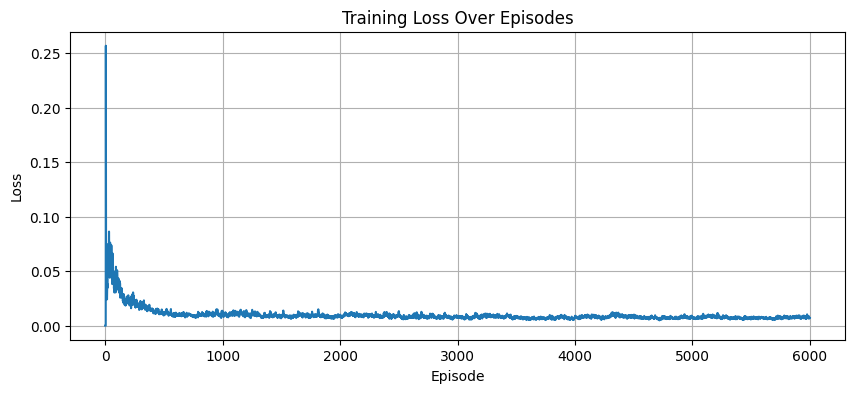

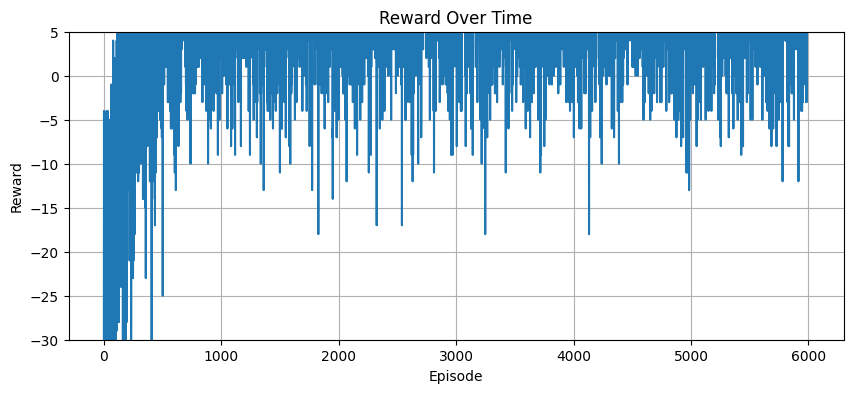

In [ ]:
# Register custom environments
register_custom_envs()

# Event preprocessing: converts raw event dict into numerical vector
# Each event has 5 features: type, fg color, bg color, start time, end time
def extract_event_vector(obs):
    return np.array([
        obs["e_type"],
        obs["fg"],
        obs["bg"],
        obs["start"][0],
        obs["end"][0]
    ], dtype=np.float32)

# Recurrent Q-Network: GRU-based model for sequential decision making
class RNN_DQN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN_DQN, self).__init__()
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, h):
        # x: (batch_size, seq_len, input_size), h: (1, batch_size, hidden_size)
        out, h = self.gru(x, h)
        out = self.fc(out[:, -1, :])  # Use last output
        return out, h

    def init_hidden(self, batch_size, device):
        return torch.zeros(1, batch_size, self.hidden_size).to(device)

# Replay buffer for experience replay
# Stores (state, action, next_state, reward) tuples
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# Define discrete action space: 3 binary buttons -> 8 combinations
action_space = list(product([0, 1], repeat=3))

# Epsilon-greedy exploration policy
# Epsilon decays over time to shift from exploration to exploitation
def select_action(state_seq, policy_net, hidden, steps_done, device, EPS_START=1.0, EPS_END=0.3, EPS_DECAY=5000):
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * np.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            q_values, _ = policy_net(state_seq, hidden)
            return q_values.argmax(dim=1).item(), steps_done
    else:
        return random.randrange(len(action_space)), steps_done

# Perform a gradient descent step on sampled batch
def optimize_model(policy_net, target_net, optimizer, memory, batch_size, gamma, device):
    if len(memory) < batch_size:
        return None

    transitions = memory.sample(batch_size)
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])

    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    h = policy_net.init_hidden(batch_size, device)
    state_action_values, _ = policy_net(state_batch, h)
    state_action_values = state_action_values.gather(1, action_batch)

    next_state_values = torch.zeros(batch_size, device=device)
    if non_final_next_states.size(0) > 0:
        h2 = target_net.init_hidden(non_final_next_states.size(0), device)
        next_q, _ = target_net(non_final_next_states, h2)
        next_state_values[non_final_mask] = next_q.max(1)[0].detach()

    expected_state_action_values = (next_state_values * gamma) + reward_batch

    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()
    return loss.item()

# Main training loop using RNN-based agent
def training_OpenTheChests_v1(env_name="OpenTheChests-v1", num_episodes=6000):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    memory = ReplayMemory(5000)
    batch_size = 128
    gamma = 0.85
    target_update = 10
    lr = 1e-2

    env = gym.make(env_name)
    input_dim = 5
    seq_len = 4
    n_actions = 8
    hidden_dim = 128

    policy_net = RNN_DQN(input_dim, hidden_dim, n_actions).to(device)
    target_net = RNN_DQN(input_dim, hidden_dim, n_actions).to(device)
    target_net.load_state_dict(policy_net.state_dict())

    optimizer = optim.Adam(policy_net.parameters(), lr=lr, amsgrad=True)

    rewards_list = []
    losses = []
    steps_done = 0

    for i_episode in range(num_episodes):
        event_history = deque(maxlen=seq_len)
        obs = env.reset()
        event_history.append(extract_event_vector(obs))

        while len(event_history) < seq_len:
            event_history.append(np.zeros(5, dtype=np.float32))

        state_seq = np.stack(event_history)[None, :, :]  # shape (1, seq_len, 5)
        state = torch.tensor(state_seq, dtype=torch.float32, device=device)
        h = policy_net.init_hidden(1, device)

        episode_loss_values = []
        reward_per_episode = 0

        for t in count():
            action_index, steps_done = select_action(state, policy_net, h, steps_done, device)
            action_vector = list(action_space[action_index])
            action_tensor = torch.tensor([[action_index]], device=device, dtype=torch.long)

            next_obs, reward, done, _ = env.step(action_vector)
            reward_tensor = torch.tensor([reward], device=device, dtype=torch.float32)
            if reward>0 :
              reward+=5
              reward_per_episode += reward
            else : reward_per_episode += reward

            if not done:
                event_history.append(extract_event_vector(next_obs))
                next_seq = np.stack(event_history)[None, :, :]
                next_state = torch.tensor(next_seq, dtype=torch.float32, device=device)
            else:
                next_state = None

            memory.push(state, action_tensor, next_state, reward_tensor)
            state = next_state

            loss = optimize_model(policy_net, target_net, optimizer, memory, batch_size, gamma, device)
            if loss is not None:
                episode_loss_values.append(loss)

            if done:
                rewards_list.append(reward_per_episode)
                avg_loss = sum(episode_loss_values)/len(episode_loss_values) if episode_loss_values else 0.0
                losses.append(avg_loss)
                break

        if i_episode % target_update == 0:
            target_net.load_state_dict(policy_net.state_dict())

    torch.save(policy_net.state_dict(), "policy_net_V1.pth")

    env.close()

    # Plot training curves: loss and rewards
    plt.figure(figsize=(10, 4))
    plt.plot(losses)
    plt.xlabel('Episode')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Episodes')
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 4))
    plt.plot(rewards_list)
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Reward Over Time')
    plt.ylim(-30,5)
    plt.grid(True)
    plt.show()

    return None

training_OpenTheChests_v1()

On peut voir sur nos courbes qu'il y a de la variance dans nos rewards mais cela converge.

In [116]:
def test_agent(env_name="OpenTheChests-v1", model_path="policy_net_V1.pth", num_episodes=22, seq_len=4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    env = gym.make(env_name)

    input_dim = 5
    hidden_dim = 128
    n_actions = 8

    policy_net = RNN_DQN(input_dim, hidden_dim, n_actions).to(device)
    policy_net.load_state_dict(torch.load(model_path))
    policy_net.eval()

    for episode in range(num_episodes):
        event_history = deque(maxlen=seq_len)
        obs = env.reset()
        event_history.append(extract_event_vector(obs))

        while len(event_history) < seq_len:
            event_history.append(np.zeros(5, dtype=np.float32))

        state_seq = np.stack(event_history)[None, :, :]
        state = torch.tensor(state_seq, dtype=torch.float32, device=device)
        h = policy_net.init_hidden(1, device)

        total_reward = 0
        for t in count():

            with torch.no_grad():
                q_values, h = policy_net(state, h)
                action_index = q_values.argmax(dim=1).item()

            action = list(action_space[action_index])
            obs, reward, done, _ = env.step(action)
            total_reward += reward

            if not done:
                event_history.append(extract_event_vector(obs))
                state_seq = np.stack(event_history)[None, :, :]
                state = torch.tensor(state_seq, dtype=torch.float32, device=device)
            else:
                print(action)
                break

        print(f"Episode {episode + 1}: Total reward = {total_reward}")

    env.close()

In [117]:
test_rewards=test_agent()

/usr/local/lib/python3.11/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment OpenTheChests-v1 is out of date. You should consider upgrading to version `v2`.
  logger.warn(
/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` 

[0, 0, 1]
Episode 1: Total reward = 2
[0, 1, 0]
Episode 2: Total reward = -58
[0, 1, 0]
Episode 3: Total reward = 3
[0, 1, 0]
Episode 4: Total reward = 3
[0, 1, 0]
Episode 5: Total reward = 3
[0, 1, 0]
Episode 6: Total reward = -58
[0, 0, 1]
Episode 7: Total reward = 3
[0, 1, 0]
Episode 8: Total reward = 3
[0, 1, 0]
Episode 9: Total reward = -58
[0, 1, 0]
Episode 10: Total reward = -58
[0, 1, 0]
Episode 11: Total reward = -58
[0, 1, 0]
Episode 12: Total reward = 3
[0, 1, 0]
Episode 13: Total reward = -58
[0, 1, 0]
Episode 14: Total reward = 3
[0, 0, 1]
Episode 15: Total reward = 3
[0, 0, 1]
Episode 16: Total reward = 3
[0, 1, 0]
Episode 17: Total reward = 3
[0, 1, 0]
Episode 18: Total reward = -62
[0, 1, 0]
Episode 19: Total reward = 1
[0, 1, 0]
Episode 20: Total reward = 3
[0, 1, 0]
Episode 21: Total reward = -58
[0, 1, 0]
Episode 22: Total reward = -58


## 3. Liaison des deux agents

In [ ]:
def robot_agent2(box):
  # Limitation des threads OpenBLAS/MKL/OMP pour éviter les warnings
  os.environ["OPENBLAS_NUM_THREADS"] = "1"
  os.environ["MKL_NUM_THREADS"]     = "1"
  os.environ["OMP_NUM_THREADS"]     = "1"

  sys.path.append('/content')
  from kuka_env_file import MultiGoalKukaEnv

  cam_target_pos = [0.85, 0.0, 0.2]   # centre de vue (milieu des 3 boîtes)
  cam_distance   = 2.0
  cam_yaw, cam_pitch, cam_roll = -40, -30, 0
  cam_width, cam_height = 640, 480
  fps = 30
  video_path = "ppo_test_episode.mp4"

  writer = imageio_ffmpeg.write_frames(
      video_path,
      (cam_width, cam_height),
      fps=fps,
      macro_block_size=1
  )
  writer.send(None)

  # Démarrage de PyBullet en headless
  client = p.connect(p.DIRECT)
  p.setAdditionalSearchPath(pybullet_data.getDataPath())
  p.setGravity(0, 0, -10, physicsClientId=client)
  
  env = MultiGoalKukaEnv()
  env.client = client

  # Charge ton modèle SB3 (sans l’extension .zip)
  model = PPO.load("/content/ppo_kuka_multigoal.zip")

  # Reset de l'env et override de la cible choisie
  obs, _ = env.reset()
  chosen_idx = box  # 0, 1 ou 2 selon la boîte visée
  chest_xy = env.chest_xy[chosen_idx]
  z = env.goal[2]  # conserve la hauteur
  env.goal = np.array([chest_xy[0], chest_xy[1], z], dtype=np.float32)

  done = False
  truncated = False

  # Boucle de rollout & capture des frames
  while not done and not truncated:
      action, _ = model.predict(obs, deterministic=True)
      obs, _, done, truncated, info = env.step(action)

      view = p.computeViewMatrixFromYawPitchRoll(
          cam_target_pos, cam_distance,
          cam_yaw, cam_pitch, cam_roll,
          upAxisIndex=2, physicsClientId=client
      )
      proj = p.computeProjectionMatrixFOV(
          fov=60,
          aspect=cam_width / cam_height,
          nearVal=0.01,
          farVal=100,
          physicsClientId=client
      )

      img = p.getCameraImage(
          cam_width, cam_height, view, proj,
          physicsClientId=client
      )[2][:, :, :3]
      writer.send(np.ascontiguousarray(img))


  writer.close()
  env.close()

In [140]:
def agent1(env_name="OpenTheChests-v1", model_path="policy_net_V1.pth", num_episodes=1, seq_len=4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    env = gym.make(env_name)

    input_dim = 5
    hidden_dim = 128
    n_actions = 8

    policy_net = RNN_DQN(input_dim, hidden_dim, n_actions).to(device)
    policy_net.load_state_dict(torch.load(model_path))
    policy_net.eval()

    for episode in range(num_episodes):
        event_history = deque(maxlen=seq_len)
        obs = env.reset()
        event_history.append(extract_event_vector(obs))

        while len(event_history) < seq_len:
            event_history.append(np.zeros(5, dtype=np.float32))

        state_seq = np.stack(event_history)[None, :, :]
        state = torch.tensor(state_seq, dtype=torch.float32, device=device)
        h = policy_net.init_hidden(1, device)

        total_reward = 0
        for t in count():

            with torch.no_grad():
                q_values, h = policy_net(state, h)
                action_index = q_values.argmax(dim=1).item()

            action = list(action_space[action_index])
            obs, reward, done, _ = env.step(action)
            total_reward += reward

            if not done:
                event_history.append(extract_event_vector(obs))
                state_seq = np.stack(event_history)[None, :, :]
                state = torch.tensor(state_seq, dtype=torch.float32, device=device)
            else:
                print(action)
                robot_agent2(np.argmax(action))
                break

        print(f"Episode {episode + 1}: Total reward = {total_reward}")

    env.close()

In [141]:
agent1()

[0, 1, 0]
Episode 1: Total reward = 3


In [142]:
mp4 = open("ppo_test_episode.mp4", "rb").read()
HTML(
            f'<video width={cam_width} controls>'
            f'<source src="data:video/mp4;base64,{b64encode(mp4).decode()}" '
            f'type="video/mp4"></video>'
        )

L’évaluation visuelle (vidéo) montre une bonne convergence de l’apprentissage et une exécution maîtrisée du comportement attendu.
On observe que :
- Le robot atteint systématiquement le bon coffre.
- Le mouvement est fluide, ciblé et sans gestes parasites, ce qui témoigne d’une politique bien apprise.
- La précision du geste indique que l'exploitation du signal de récompense est efficace.

### Pour aller plus loin: 

Afin de faire évoluer la simple tâche implémentée qui est de toucher le cube, on pourrait introduire plusieurs étapes pour structurer la complexité de l’apprentissage. Une décomposition en phases successives permettrait un contrôle plus fin du comportement du robot. Par exemple : (1) toucher la boîte avec précision, (2) stabiliser le gripper à une hauteur définie au-dessus du cube, (3) ouvrir les pinces au maximum, (4) descendre pour aligner les pinces avec le centre du cube, et enfin (5) refermer fermement les pinces puis remonter. 

Ce processus progressif met en évidence que la gestion fine des contraintes de l’environnement (mouvements permis, tolérances, stabilisation) est cruciale. Lors des premières phases, il peut être pertinent de restreindre certains degrés de liberté pour concentrer l’apprentissage sur des sous-tâches précises (par exemple, le déplacement du bras sans activation du gripper), avant de relâcher progressivement ces contraintes à mesure que les capacités de l’agent se développent.

# Annexe

## Relevant Documentation and Libraries

To better understand and implement the project, the following resources and libraries are recommended:

### Reinforcement Learning Libraries:
- **Stable Baselines3**: RL framework with pre-implemented algorithms. [📖 Documentation](https://stable-baselines3.readthedocs.io/en/master/)
- **Gymnasium (formerly OpenAI Gym)**: Toolkit for developing RL environments. [📖 Documentation](https://gymnasium.farama.org/)
- **RL Baselines3 Zoo**: Collection of pre-trained RL agents. [📖 GitHub](https://github.com/DLR-RM/rl-baselines3-zoo)

### Robotic Simulation:
- **PyBullet**: Physics engine for robotic simulations. [📖 Documentation](https://pybullet.org/) [📖 Quicktart Guide](https://docs.google.com/document/d/10sXEhzFRSnvFcl3XxNGhnD4N2SedqwdAvK3dsihxVUA/edit?tab=t.0)
- **KUKA Arm (KukaBulletEnv-v0)**: PyBullet environment for KUKA robot arm control. [📖 Example](https://github.com/bulletphysics/bullet3/tree/master/examples/pybullet/gym/pybullet_envs) [📖 Example](https://github.com/bulletphysics/bullet3/blob/master/examples/pybullet/gym/pybullet_envs/__init__.py)
- **Reacher**: Simulated environment for reaching tasks. [📖 Documentation](https://www.gymlibrary.dev/environments/mujoco/reacher/)

### Open the Chests (OtC) Environment:
- **OtC Environment Overview**: Sequential event-based RL scenario. [📖  GitHub ](https://github.com/ThalesGroup/open-the-chests) [📖 Article ](https://drops.dagstuhl.de/entities/document/10.4230/LIPIcs.TIME.2024.5) [📖 Presentation ](https://www.lirmm.fr/time2024/files/OpenTheChestsTIME2024.pdf)


## 1. RL Environment with PyBullet

### **References**
- **Gymnasium (formerly OpenAI Gym) Documentation**  
  - [Environment Creation Tutorial](https://gymnasium.farama.org/tutorials/gymnasium_basics/environment_creation/)  
  - [Gym Library Environment Creation](https://www.gymlibrary.dev/content/environment_creation/)  

- **Custom PyBullet Robot Arm Projects**  
  - [PyBullet Tutorial](https://www.etedal.net/2020/04/pybullet-panda_2.html)  
  - [Multi-Goal PyBullet Gym](https://github.com/IanYangChina/pybullet_multigoal_gym/tree/master)  